# Исследование рынка общественного питания г. Москва

# Оглавление
1. [Описание проекта](#title)
2. [Загрузка данных и подготовка их к анализу](#load)
  * [Подключение библиотек](#import)
  * [Загрузка данных и получение общей информации](#info)
3. [Анализ данных](#analysis)
 - [Анализ соотношение типов объектов общественного питания по количеству](#analysis_type)
 - [Анализ соотношения сетевых и несетевых заведений по количеству](#analysis_chain)
 - [Изучение информации о количестве посадочных мест](#analysis_seats)
 - [Улицы и районы с наибольшим количеством объектов общественного питания](#analysis_streets1)
 - [Улицы с одним объектом общественного питания](#analysis_streets2)
 - [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#analysis_streets1_seats)
4. [Общий вывод](#conclusion)

<a id="title"></a> 
## Описание проекта

Цель проекта: определение возможного вида заведения общественного питания, количества посадочных мест, района расположения, для дальнейшего открытия и развития заведения в г.Москва

**Описание данных**
Таблица rest_data:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

<a id="load"></a> 
## Загрузка данных и подготовка их к анализу

<a id="import"></a> 
### Подключение библиотек

In [120]:
import pandas as pd
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px 
import seaborn as sns
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import numpy as np
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')
register_matplotlib_converters()

<a id="info"></a> 
### Загрузка данных и получение общей информации

In [68]:
data = pd.read_csv('/datasets/rest_data.csv')

In [69]:
def inspect (df):
    display(df.sample(n = 5, random_state = 5)) #посмотрим случайные строки
    df.info() 
    print ('Количество полных дубликатов - ' + str(df.duplicated().sum()))

In [70]:
inspect(data)

,id,object_name,chain,object_type,address,number
7628,84358,Шоколадница,да,кафе,"город Москва, проспект Андропова, дом 8",25
13524,214230,Выпечка,нет,магазин (отдел кулинарии),"город Москва, 1-я Владимирская улица, дом 43",0
33,69243,Суши Wok,да,кафе,"город Москва, проспект Андропова, дом 30",4
1101,156704,KFC,да,ресторан,"город Москва, Страстной бульвар, дом 4, строен...",160
1397,149825,Домино'с Пицца,да,кафе,"город Москва, Ярославское шоссе, дом 55, корпус 1",10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
Количество полных дубликатов - 0


In [71]:
# проверим на дубликаты без учета колонки id
data.duplicated(subset = ['object_name', 'chain', 'object_type', 'address', 'number']).sum()

82

In [72]:
# удалим 82 дубликата
data.drop_duplicates(subset = ['object_name', 'chain', 'object_type', 'address', 'number'], inplace = True)

Вывод:
- пропуски и явные дубликаты в данных отсутствуют
- названия колонок и типы данных корректны, тип данных в колонке chain можно привести к типу bool, при необходимости сделаем это по ходу анализа
- удалено 82 дубликата с одиниковыми параметрами (кроме id), если бы в адресе отсутствовал номер дома, то можно было бы предположить что это действительно одинаковые объекты на одной улице, но при такой детализации это действительно дубликаты

<a id="analysis"></a>
## Анализ данных

<a id="analysis_type"></a>
### Анализ соотношение типов объектов общественного питания по количеству

In [73]:
group_by_type = data.groupby('object_type').agg({'id': 'count'}).reset_index().sort_values('id', ascending = False)
group_by_type

,object_type,id
3,кафе,6071
8,столовая,2584
7,ресторан,2282
6,предприятие быстрого обслуживания,1898
0,бар,855
1,буфет,577
4,кафетерий,395
2,закусочная,349
5,магазин (отдел кулинарии),273


In [74]:
# имеется два очень длинных названия, которое будут нам мешать при постороении графиков
data.loc[data['object_type']=='предприятие быстрого обслуживания', 'object_type'] = 'фастфуд'
data.loc[data['object_type']=='магазин (отдел кулинарии)', 'object_type'] = 'отдел кулинарии'
group_by_type = data.groupby('object_type').agg({'id': 'count'}).reset_index().sort_values('id', ascending = False)
group_by_type['part'] = (group_by_type['id']/group_by_type['id'].sum()).round(2)
group_by_type

,object_type,id,part
3,кафе,6071,0.40
7,столовая,2584,0.17
6,ресторан,2282,0.15
8,фастфуд,1898,0.12
0,бар,855,0.06
1,буфет,577,0.04
4,кафетерий,395,0.03
2,закусочная,349,0.02
5,отдел кулинарии,273,0.02


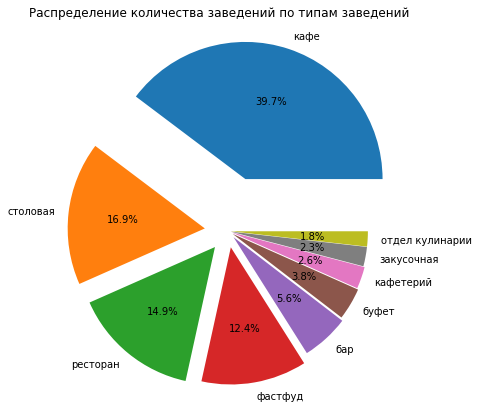

In [75]:
fig, ax = plt.subplots()
ax.pie(group_by_type['id'], labels=group_by_type['object_type'], autopct='%1.1f%%', explode = group_by_type['part'])
ax.axis("equal")
fig.set_figheight(7)  
fig.set_figwidth(7) 
plt.title('Распределение количества заведений по типам заведений', loc = 'left') 
plt.show()

Вывод: больше всего у нас кафе, столовых и ресторанов

<a id="analysis_chain"></a>
### Анализ соотношения сетевых и несетевых заведений по количеству

In [76]:
group_by_chain = data.groupby('chain').agg({'id': 'count'}).sort_values('id', ascending=False).assign(pct_total=lambda x: x / x.sum()).round(2)
group_by_chain

,id,pct_total
chain,,
нет,12320,0.81
да,2964,0.19


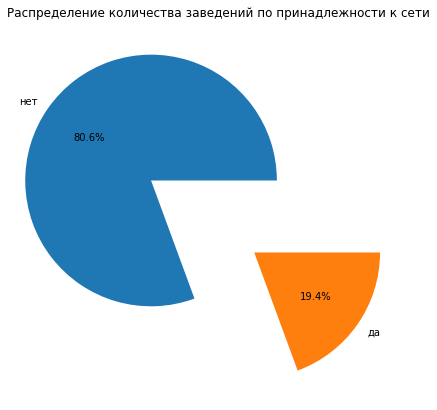

In [77]:
fig, ax = plt.subplots()
ax.pie(group_by_chain['id'], labels=group_by_chain.index, autopct='%1.1f%%', explode = group_by_chain['pct_total'])
ax.axis("equal")
fig.set_figheight(7)  
fig.set_figwidth(7) 
plt.title('Распределение количества заведений по принадлежности к сети', loc = 'left') 
plt.show()

In [78]:
# проверим имеются ли у нас сетевые заведения имеющие пока только  1 заведение
chain_with_one_object = data.query('chain == "да"').groupby(['object_name', 'chain']).agg({'id': 'count'}).reset_index()
chain_with_one_object.query('id==1')

,object_name,chain,id
0,Beverly Hills Diner,да,1
1,Bierloga,да,1
2,Black & White,да,1
4,BooBo,да,1
5,Bubbleology,да,1
...,...,...,...
718,кафе «Нияма»,да,1
719,кафе «Папа Джонс»,да,1
721,кафе «Шоколадница»,да,1
722,ресторан «Брудер»,да,1


Очень странно из 2 968 сетевых заведений, 450 имеют только 1 заведение, возможно они планируются как сетевые но еще не открыли дополнительные точки, возможно ошибка в принадлежности к сети, а возможно у заведений одной сети могут быть разные названия. Повод ли это переводить их в несетевые? Данных для принятия такого решения недостаточно.

In [79]:
potato = []
for i in data['object_name']:
    if 'Крошка Картошка' in i:
        potato.append(i)

from collections import Counter
Counter(potato)

Counter({'Крошка Картошка': 82,
         'Предприятие быстрого обслуживания «Крошка Картошка»': 1,
         'Закусочная «Крошка Картошка»': 1,
         'Кафе «Крошка Картошка»': 2,
         'Ресторан быстрого питания «Крошка Картошка»': 1,
         'Предприятие быстрого питания «Крошка Картошка»': 1})

Мы видим что есть заведения которые в точности не совпадают, однако можно подозревать при этом их принадлежность к одной сети

In [80]:
group_by_type_chain = data.pivot_table(index = 'object_type', columns = 'chain', values = 'id', aggfunc='count')
group_by_type_chain.columns = ['chain', 'not_chain']
group_by_type_chain['part_chain_in total'] = (group_by_type_chain['chain']/
                                              (group_by_type_chain['chain']+group_by_type_chain['not_chain'])).round(2)
group_by_type_chain

,chain,not_chain,part_chain_in total
object_type,,,
бар,37,818,0.04
буфет,11,566,0.02
закусочная,56,293,0.16
кафе,1396,4675,0.23
кафетерий,52,343,0.13
отдел кулинарии,78,195,0.29
ресторан,543,1739,0.24
столовая,3,2581,0.00
фастфуд,788,1110,0.42


Завдений у нас больше не сетевых, а среди сетевых чаще всего встречаются кафе, предприятия быстрого обслуживания и рестораны

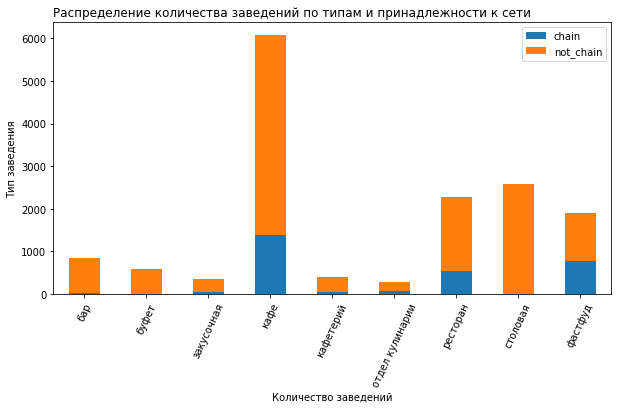

In [81]:
group_by_type_chain[['chain', 'not_chain']].plot(kind='bar', figsize=(10, 5), stacked = True)
plt.title('Распределение количества заведений по типам и принадлежности к сети', loc = 'left') 
plt.xlabel('Количество заведений') 
plt.ylabel('Тип заведения')
#plt.grid(True)
plt.xticks(rotation= 65)
plt.show()

Вывод: в Москве наибольшее количество заведений приходится на кафе, столовые и рестораны, при этом среди сетевых завдений больше всего кафе, предприятия быстрого обслуживания и рестораны, среди столовых сетевых практически нет.
Наибольшую долю сетевых среди всех типов имеют предприятия быстрого обслуживания, т.е. среди них такая форма наиболее распростаренена.

<a id="analysis_seats"></a>
### Изучение информации о количестве посадочных мест

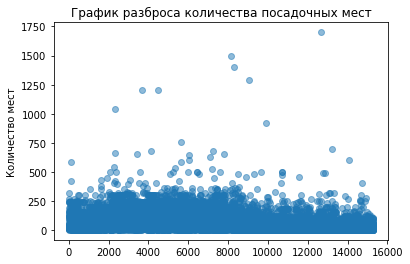

In [82]:
# проанализируем колонку с числом посадочных мест
x_values = pd.Series(range(0,len(data['number'])))
plt.title('График разброса количества посадочных мест')
plt.ylabel('Количество мест')
plt.scatter(x_values, data['number'], alpha = 0.5) 

In [83]:
data['number'].describe()

count    15284.000000
mean        59.784350
std         74.838657
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Имеются как заведения без посадочных мест, скорее всего работающие " на вынос", так и возможно банкетные залы до 1700 посадочных мест

In [84]:
chain_objects = data.query('chain=="да"').pivot_table(index = 'object_name', values = ['id', 'number'], 
                                      aggfunc = {'id': 'count', 'number': 'mean'}).sort_values('number', ascending = False).reset_index()

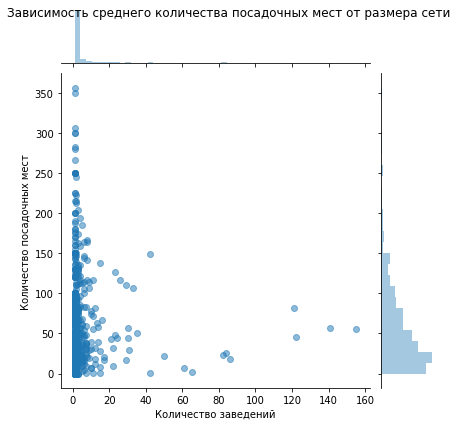

In [85]:
fg = sns.jointplot(x='id', y='number', data=chain_objects, alpha = 0.5) 
fg.set_axis_labels("Количество заведений", "Количество посадочных мест")
fg.fig.suptitle('Зависимость среднего количества посадочных мест от размера сети')
plt.show()

Можно сказать, что для сетевого общепита Москвы более характерны сетевые завдения с небольшим количеством зведений (до 12 ти) и числом постадочных мест до 100.

In [86]:
# определим среднее количество посадочных мест для каждого вида объекта общественного питания
data_grouped = data.pivot_table(index = 'object_type', values = 'number', aggfunc='mean').sort_values(
    'number', ascending = False).round(0)

In [87]:
data_grouped = data_grouped.merge(data.pivot_table(index = 'object_type', columns = 'chain', values = 'number', aggfunc='mean').round(0), on = 'object_type')
data_grouped.columns = ['total_seats', 'chain', 'not_chain']
data_grouped

,total_seats,chain,not_chain
object_type,,,
столовая,130.0,112.0,130.0
ресторан,97.0,100.0,96.0
буфет,52.0,13.0,52.0
бар,44.0,53.0,43.0
кафе,40.0,47.0,38.0
фастфуд,21.0,40.0,7.0
кафетерий,9.0,12.0,9.0
закусочная,8.0,14.0,7.0
отдел кулинарии,6.0,9.0,4.0


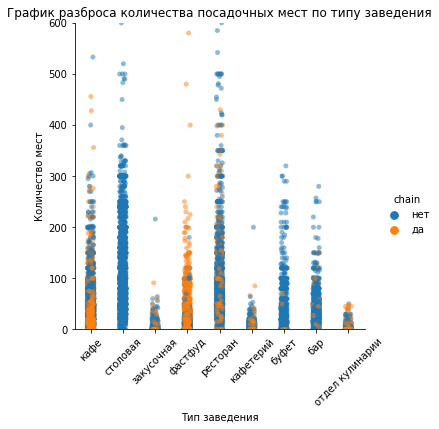

In [88]:
sns.catplot(data=data, x='object_type', y='number', hue='chain', alpha = 0.5)
plt.xticks(rotation= 45)
plt.title('График разброса количества посадочных мест по типу заведения')
plt.xlabel('Тип заведения')
plt.ylabel('Количество мест')
plt.ylim(0, 600)
plt.show()

In [89]:
# проверим гипотезу о равенстве средних
# Нулевая гипотеза: среднее количество посадочных мест для сетевых и несетевых заведений совпадают. 
# Альтернативная гипотеза: среднее количество посадочных мест для сетевых и несетевых заведений разные.
sample_1 = data.query('chain =="да"')['number']
sample_2 = data.query('chain =="нет"')['number']
results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.489945479862341e-08
Отвергаем нулевую гипотезу


Вывод: 
- для сетевого общепита Москвы более характерны сетевые заведения с небольшим количеством заведений (до 12 ти) и числом посадочных мест до 100.
- наибольшее количество посадочных мест у столовых, далее идут рестораны и буфеты
- среднее количество посадочных мест у сетевых и не сетевых заведений отличается, что касается наиболее распростараненного среди не сетевых - предприятий быстрого обслуживания, их среднее число посадочных мест больше чем у аналогичных не сетевых

<a id="analysis_streets1"></a>
### Улицы и районы с наибольшим количеством объектов общественного питания

In [90]:
# Выделим в отдельный столбец информацию об улице из столбца address
data['address'].unique()

array(['город Москва, улица Егора Абакумова, дом 9',
       'город Москва, улица Талалихина, дом 2/1, корпус 1',
       'город Москва, Абельмановская улица, дом 6', ...,
       'город Москва, Салтыковская улица, дом 7Г',
       'город Москва, Осенний бульвар, дом 9',
       'город Москва, улица Новый Арбат, дом 13'], dtype=object)

In [91]:
data['city'] = data['address'].str.split(', ', expand=True)[0]
data['street'] = data['address'].str.split(', ', expand=True)[1]
data.head()

,id,object_name,chain,object_type,address,number,city,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,город Москва,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,город Москва,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,город Москва,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,город Москва,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,город Москва,Абрамцевская улица


In [92]:
# проверим, что в данных присутствует только Москва
data['city'].value_counts()

город Москва                     15213
улица Ленинская Слобода              4
Николоямская улица                   4
город Московский                     3
улица Льва Толстого                  3
Солянский тупик                      3
Таганская площадь                    2
2-я Брестская улица                  2
Бауманская улица                     2
Ленинградский проспект               2
Партизанская улица                   2
Вспольный переулок                   1
Шарикоподшипниковская улица          1
Поречная улица                       1
Нижний Таганский тупик               1
1-я Тверская-Ямская улица            1
Алтуфьевское шоссе                   1
Краснобогатырская улица              1
Тушинская улица                      1
Большая Бронная улица                1
1-й Нагатинский проезд               1
Профсоюзная улица                    1
поселение Марушкинское               1
поселение "Мосрентген"               1
Погодинская улица                    1
Большая Серпуховская улиц

In [93]:
data.query('city=="Николоямская улица"')

,id,object_name,chain,object_type,address,number,city,street
8759,21845,Шоколадница,да,кафе,"Николоямская улица, дом 28/60, строение 1",56,Николоямская улица,дом 28/60
8760,25859,ДжонДжоли,нет,ресторан,"Николоямская улица, дом 28/60, строение 1",90,Николоямская улица,дом 28/60
10505,179007,Караоке Song Vape BAR STEAK HOUSE,нет,ресторан,"Николоямская улица, дом 28/60, строение 1",40,Николоямская улица,дом 28/60
12704,202752,The Rooms,нет,кафе,"Николоямская улица, дом 38/14/23, строение 3",150,Николоямская улица,дом 38/14/23


Формат данных столбца adress не везде был одинаков, поэтому колонка с городом и улицей заполнена корректно не по всем строкам, кроме того в данных есть, например,  город Троицк, данные по которому нам для анализа общепита Москвы не  нужны. Это вызывает вопросы к источнику данных. Попробуем по возможности исправить данные в колонках город и улица. Предположим , что там где город или поселение, не указаны, объект относится к городу Москва

In [94]:
['город', 'поселение']
for city in data['city']:
    if 'город' not in city: 
        if 'поселение' not in city:
            data.loc[data['city']==city, 'street'] = data.loc[data['city']==city, 'city']
            data.loc[data['city']==city, 'city'] = 'город Москва'

In [95]:
data['city'].value_counts()

город Москва                     15276
город Московский                     3
поселение Михайлово-Ярцевское        1
поселение Сосенское                  1
город Троицк                         1
поселение Марушкинское               1
поселение "Мосрентген"               1
Name: city, dtype: int64

In [96]:
# оставим для анализа только объекты города Москва
mos = data.query('city=="город Москва"')

In [97]:
# найдем топ-10 улиц по количеству объектов общественного питания
top_streets = mos.pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index().sort_values('id', ascending = False).head(10)
top_streets.columns = ['street', 'number_of_objects']
top_streets

,street,number_of_objects
1333,город Зеленоград,232
1406,проспект Мира,204
996,Профсоюзная улица,182
683,Ленинградский проспект,172
981,Пресненская набережная,167
406,Варшавское шоссе,162
686,Ленинский проспект,148
1373,поселение Сосенское,137
1403,проспект Вернадского,128
674,Кутузовский проспект,114


In [114]:
# как то в топ улиц москвы у нас все равно прорвался город и поселение Сосенское, проверим почему
data.query('street =="город Зеленоград" or street =="поселение Сосенское"')

,id,object_name,chain,object_type,address,number,city,street
1386,22331,СТОЛОВАЯ МИЭТ,нет,столовая,"город Москва, город Зеленоград, улица Юности, ...",56,город Москва,город Зеленоград
1405,20199,ЭТО,нет,кафе,"город Москва, город Зеленоград, корпус 401",35,город Москва,город Зеленоград
1406,68113,Френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,город Москва,город Зеленоград
1407,20105,Кафе «Граф Монте-Кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,город Москва,город Зеленоград
1408,22982,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",49,город Москва,город Зеленоград
...,...,...,...,...,...,...,...,...
15137,209920,Дюшес,да,ресторан,"город Москва, город Зеленоград, Проезд № 4806,...",100,город Москва,город Зеленоград
15169,213387,Cofix,да,кафе,"город Москва, поселение Сосенское, Калужское ш...",15,город Москва,поселение Сосенское
15183,205739,Пицца Паоло и Бенто WOK,да,кафе,"город Москва, город Зеленоград, Панфиловский п...",30,город Москва,город Зеленоград
15184,220587,Пицца Паоло,да,кафетерий,"город Москва, город Зеленоград, корпус 1627",0,город Москва,город Зеленоград


Понятно, указан город Москва

In [118]:
# очень странно, но все таки Зеленоград это отдельный город, который асположен в 37 км к северо-западу от центра Москвы
# исключим и данные по нему
mos = mos.query('street !="город Зеленоград" and street !="поселение Сосенское"')
# найдем топ-10 улиц по количеству объектов общественного питания еще раз
top_streets = mos.pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index().sort_values('id', ascending = False).head(10)
top_streets.columns = ['street', 'number_of_objects']
top_streets

,street,number_of_objects
1404,проспект Мира,204
996,Профсоюзная улица,182
683,Ленинградский проспект,172
981,Пресненская набережная,167
406,Варшавское шоссе,162
686,Ленинский проспект,148
1401,проспект Вернадского,128
674,Кутузовский проспект,114
600,Каширское шоссе,111
605,Кировоградская улица,108


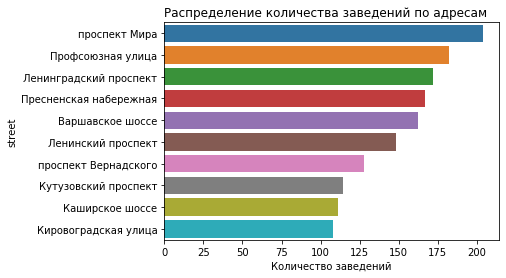

In [119]:
sns.barplot(x='number_of_objects', y='street', data=top_streets) 
plt.title('Распределение количества заведений по адресам', loc = 'left') 
plt.xlabel('Количество заведений') 
plt.show()

In [121]:
# добавим таблицу с данными о районах

spreadsheet_id = '1SAIybsv7tb-No5KXRnkka1Pr2I1Q5Uk7ZuANaQjkI_I'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

In [122]:
# дополним таблицу с топ-10 улиц по количеству объектов общественного питания данными о районах
top_areas = top_streets.merge(df.drop(['areaid', 'okrug'], 1), left_on = 'street', right_on = 'streetname')

In [123]:
# получим список районов с наибольшим количеством заведений
top_areas_list = top_areas[['area', 'lat', 'lon']].drop_duplicates().reset_index(drop=True).merge(
    top_areas.groupby('area')['number_of_objects'].sum(), on = 'area')

In [126]:
top_areas_list.sort_values('number_of_objects', ascending=False).head()

,area,lat,lon,number_of_objects
12,Район Теплый Стан,55.629548,37.483494,330
11,Обручевский район,55.660876,37.518370,330
21,Донской район,55.699895,37.607040,310
29,Ломоносовский район,55.679163,37.533962,276
28,Район Гагаринский,55.691242,37.546741,276


In [127]:
# нанесем полученные районы на карту
import plotly.graph_objs as go
#55.75256588177121, 37.61728330709825

fig = go.Figure(go.Scattermapbox(lat=top_areas_list['lat'], lon=top_areas_list['lon'], text=top_areas_list['area']
                                ,marker=dict(size=top_areas_list['number_of_objects']*0.05)))
fig.update_layout(mapbox_style="open-street-map")
map_center = go.layout.mapbox.Center(lat=55.75256588177121, lon=37.617283307098255)
fig.update_layout(mapbox_style="open-street-map",
                  mapbox=dict(center=map_center, zoom=9
                             ))
fig.show()

Вывод: районы с наибольшим количеством заведений: Район Теплый Стан, Обручевский район, Донской район, Ломоносовский район, Район Гагаринский

<a id="analysis_streets2"></a>
### Улицы с одним объектом общественного питания

In [128]:
streets = mos.pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index()
streets.columns = ['street', 'number_of_objects']
streets_with_one_object = streets.query('number_of_objects==1')
streets_with_one_object

,street,number_of_objects
2,1-й Балтийский переулок,1
3,1-й Басманный переулок,1
4,1-й Ботанический проезд,1
7,1-й Вешняковский проезд,1
9,1-й Голутвинский переулок,1
...,...,...
1837,улица Шеногина,1
1840,улица Шумилова,1
1841,улица Шумкина,1
1845,улица Щорса,1


Имеется 541 улица с одним объектом общественного питания

In [135]:
# добавим данные о районах
areas_with_one_object = streets_with_one_object.merge(df.drop(['areaid', 'okrug', 'lat', 'lon'], 1), 
                                                      left_on = 'street', right_on = 'streetname')
#areas_with_one_object_list = pd.DataFrame(areas_with_one_object['area'].unique())
#areas_with_one_object_list.columns = ['area_name']
#areas_with_one_object_list
areas_with_one_object.pivot_table(index = 'area', values = 'street', 
                                  aggfunc = 'count').sort_values('street', ascending = False).head(5)

,street
area,
Таганский район,27
Район Хамовники,26
Басманный район,25
Пресненский район,20
Тверской район,20


При этом часть районов может пересекаться, поскольку в одном районе могут быть как улицы с 1 заведением, так и улицы с большим количеством заведений

Вывод: определены улицы, на которых расположен только один объект общественного питания, и соотвествующие им районы.

Все районы с наибольшим количеством улиц с одним заведением расположены в Центральном административном округе, имеют большую протяженность от 7 до 11 Га, не удивительно что по ним проходит так много улиц.
Возможно стоимость аренды не позволяет открывать там больше заведений, поскольку в этом районе расположены много театров, вокзалы, большинство министерств Российской Федерации, а также Кремль.

<a id="analysis_streets1_seats"></a>
### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

In [107]:
#pivot = top_streets.pivot_table(index = 'street', values = 'id', aggfunc = 'count').reset_index().sort_values('id', ascending = False)
top_streets

,street,number_of_objects
1405,проспект Мира,204
996,Профсоюзная улица,182
683,Ленинградский проспект,172
981,Пресненская набережная,167
406,Варшавское шоссе,162
686,Ленинский проспект,148
1372,поселение Сосенское,137
1402,проспект Вернадского,128
674,Кутузовский проспект,114
600,Каширское шоссе,111


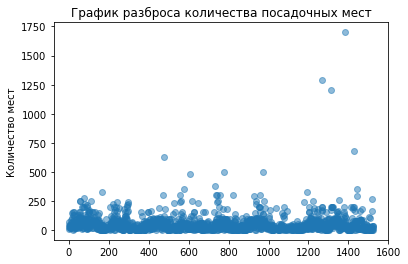

In [108]:
plot = top_streets.merge(data, on = 'street')
x_values = pd.Series(range(0,len(plot['id'])))
plt.title('График разброса количества посадочных мест')
plt.ylabel('Количество мест')
plt.scatter(x_values, plot['number'], alpha = 0.5) 
plt.show()

Очевидных отличий от всех улиц не видно, с другой стороны, это улицы на которые приходятся основные посадочные места

In [109]:
pivot = plot.pivot_table(index = 'street', values= ['id', 'number'], 
                 aggfunc = {'id': 'count', 'number': 'mean'}).sort_values('id', ascending = False).round(0)
pivot.columns = ['number_of_objects', 'mean_number_of_seats']
pivot

,number_of_objects,mean_number_of_seats
street,,
проспект Мира,204,63.0
Профсоюзная улица,182,48.0
Ленинградский проспект,172,52.0
Пресненская набережная,167,46.0
Варшавское шоссе,162,53.0
Ленинский проспект,148,63.0
поселение Сосенское,137,23.0
проспект Вернадского,128,69.0
Кутузовский проспект,114,85.0


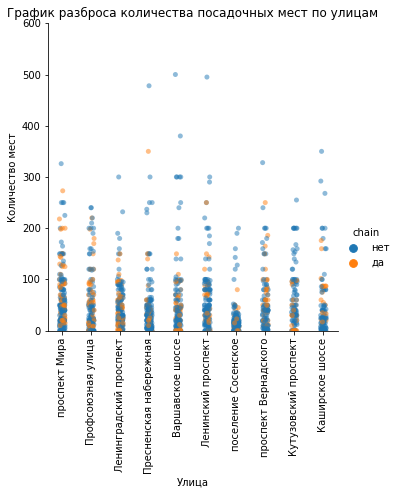

In [110]:
sns.catplot(data=plot, x='street', y='number', hue='chain', alpha = 0.5)
plt.xticks(rotation= 90)
plt.title('График разброса количества посадочных мест по улицам')
plt.xlabel('Улица')
plt.ylabel('Количество мест')
plt.ylim(0, 600)
plt.show()

Вывод: среднее количество посадочных мест для улиц с большим количеством заведений не превышает 100, наименьшее количество посадочных мест в отделах кулинарии, закусочных и кафетериях, наибольшее встречается у столовых и ресторанах. Очень мало посадочных мест более 500, возможно это обусловлено высокой арендой, либо невозможностью заполнить такие площади ввиду большой конкуренции

<a id="conclusion"></a>
## Общий вывод

Для целей проведенного анализа данных предварительно были:
- проверено наличие пропусков и явных дубликатов
- прверены названия колонок и типы данных

В результате исследовательского анализа данных определено что:
- наибольшее количество заведений представляют  кафе (39,7%) , столовые (16,9%) и рестораны (14,9%)
- к сетевым принадлежит только 19% заведений, кроме того из них 450 имеют только 1 заведение, возможно они планируются как сетевые но еще не открыли дополнительные точки, возможно ошибка в принадлежности к сети, а возможно у заведений одной сети могут быть разные названия
- имеются как заведения без посадочных мест, скорее всего работающие " на вынос", так и возможно банкетные залы до 1700 посадочных мест
- для сетевого общепита Москвы более характерны сетевые заведения с небольшим количеством зведений (до 12 ти) и числом посадочных мест до 100.
- наибольшее количество посадочных мест у столовых, далее идут рестораны и буфеты
- среднее количество посадочных мест у сетевых и не сетевых заведений отличается, что касается наиболее распространенного среди не сетевых - предприятий быстрого обслуживания, их среднее число посадочных мест больше чем у аналогичных не сетевых
- районы с наибольшим количеством заведений: Район Теплый Стан, Обручевский район, Донской район, Ломоносовский, Район Гагаринский - это сереро-запад Москвы
- определены улицы, на которых расположен только один объект общественного питания, и соотвествующие им районы.
Ввиду отсутствия данных о посещаемости и  доходах этих завдений, нельзя сделать вывод о том, имеет ли смысл открывать новое завдение в этих районах, но можно предположить что маленькое количество заведений обусловлено либо низкой проходимостьв в этих местах, либо низкой востребованностью услуг общепита

**Рекомедации:**
Если исходить из предположения, что наиболее типичные для Москвы закономерности и есть те, что мы ищем для применения к своему заведению, то можно предложить следующее:
- начать с одного несетевого заведения, далее по результатам можно будет развить сеть
- отдел кулинарии, закусочная, столовая, кафетерий и буфет нам не подойду, там скорее всего низкий средний чек , при этом вложений в наше высокотехнологичное кафе должно будет необходимо много.
- рестораны ценятся именно качеством индивидуального обслуживания, сервисом - не подходит
- скорее всего наш формат это бар, кафе, фастфуд либо кафе
- количество посадочных мест примерно 40
- район можно взять исходя из наиболее популярных районов, определенных в пункте 3.4. (Район Теплый Стан, Обручевский район, Донской район, Район Тропарево-Никулино, Район Гагаринский), но возможно рассмотреть в них улицы 1-2 заведениями, либо вообще без оных, но все же близкие к скоплению остальных заведений


Презентация
https://drive.google.com/file/d/11zd2OiOKjiPHAG_XhCiaelqJi4slQ2Bm/view?usp=sharing